<a href="https://colab.research.google.com/github/rohita77/Utils/blob/master/Google_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Imports and Installs

In [0]:
!pip install google.cloud.vision
!pip install google.cloud.storage

In [0]:
!apt-get -qq install -y google.protobuf

In [0]:
!export GOOGLE_APPLICATION_CREDENTIALS='ml-poc-1142c4445276.json'

In [0]:
 from google.cloud import vision
 from google.cloud import storage
 from google.protobuf import json_format
 import re
import numpy as np

In [0]:
import argparse
from enum import Enum
import io
import requests
from six.moves.urllib.request import urlopen
from six import BytesIO


In [0]:
from google.cloud.vision import types
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


In [0]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5

## 2. Settings

In [0]:
key_path = 'ml-poc-1142c4445276.json'

In [0]:
gcs_uri = 'https://storage.googleapis.com/'

In [0]:
client = vision.ImageAnnotatorClient.from_service_account_json(key_path)

## 3. Definitions

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


In [0]:
def detect_document_uri(uri):
    """Detects document features in the file located in Google Cloud
    Storage."""
    image = vision.types.Image()
    image.source.image_uri = uri

    response = client.document_text_detection(image=image)
   
    for page in response.full_text_annotation.pages:
      
        for block in page.blocks:
            print('\nBlock confidence: {:.2f}\n'.format(block.confidence))

            for paragraph in block.paragraphs:
                print('Paragraph confidence: {:.2f}'.format(
                    paragraph.confidence))

                for word in paragraph.words:
                    word_text = ''.join([
                        symbol.text for symbol in word.symbols
                    ])
                    print('Word text: {} ({:.1f})'.format(
                        word_text, word.confidence))

                    #for symbol in word.symbols:
                     #   print('\tSymbol: {} (confidence: {})'.format(
                      #      symbol.text, symbol.confidence))
            
        return response.full_text_annotation

In [0]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

     
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], width=2,fill=color)
    return image

In [0]:
def get_document_bounds(document, feature):
    """Returns document bounds given an image."""

    bounds = []

    # Collect specified feature bounds by enumerating all document features
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)

                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)

                if (feature == FeatureType.PARA):
                    bounds.append(paragraph.bounding_box)

            if (feature == FeatureType.BLOCK):
                bounds.append(block.bounding_box)

        if (feature == FeatureType.PAGE):
            bounds.append(block.bounding_box)

    # The list `bounds` contains the coordinates of the bounding boxes.
    return bounds

In [0]:
def render_doc_text(uri, fileout):
    #image = Image.open(filein)
    
    #image = vision.types.Image()
    #image.source.image_uri = filein
    
    #response = client.document_text_detection(image=image)

    ext = uri[-4:]
    
    if ext.find('.tif') > -1 :
      document = async_detect_document('gs://' + uri, fileout)
    else:
      document = detect_document_uri('gs://' + uri)
 

    response = urlopen(gcs_uri + uri)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  
  
    bounds = get_document_bounds(document, FeatureType.PAGE)
    draw_boxes(image, bounds, 'blue')
    bounds = get_document_bounds(document, FeatureType.PARA)
    draw_boxes(image, bounds, 'red')
    bounds = get_document_bounds(document, FeatureType.WORD)
    draw_boxes(image, bounds, 'yellow')

    #display_image(image)

#    if fileout is not 0:
#        image.save(fileout)
#
    # Here we print the full text from the first page.
    # The response contains more information:
    # annotation/pages/blocks/paragraphs/words/symbols
    # including confidence scores and bounding boxes
    print(u'Full text:\n{}'.format(
        document.text))
    
    return image

In [0]:
def async_detect_document(gcs_source_uri, gcs_destination_uri):
    """OCR with PDF/TIFF as source files on GCS"""
    # Supported mime_types are: 'application/pdf' and 'image/tiff'
    mime_type = 'image/tiff'

    # How many pages should be grouped into each json ou9tput file.
    batch_size = 2

    client = vision.ImageAnnotatorClient.from_service_account_json(key_path)

    feature = vision.types.Feature(
        type=vision.enums.Feature.Type.DOCUMENT_TEXT_DETECTION)

    gcs_source = vision.types.GcsSource(uri=gcs_source_uri)
    input_config = vision.types.InputConfig(
        gcs_source=gcs_source, mime_type=mime_type)

    gcs_destination = vision.types.GcsDestination(uri=gcs_destination_uri)
    output_config = vision.types.OutputConfig(
        gcs_destination=gcs_destination, batch_size=batch_size)

    async_request = vision.types.AsyncAnnotateFileRequest(
        features=[feature], input_config=input_config,
        output_config=output_config)

    operation = client.async_batch_annotate_files(
        requests=[async_request])

    print('Waiting for the operation to finish.')
    operation.result(timeout=180)

    # Once the request has completed and the output has been
    # written to GCS, we can list all the output files.
    storage_client = storage.Client.from_service_account_json(key_path)

    match = re.match(r'gs://([^/]+)/(.+)', gcs_destination_uri)
    bucket_name = match.group(1)
    prefix = match.group(2)

    bucket = storage_client.get_bucket(bucket_name=bucket_name)

    # List objects with the given prefix.
    blob_list = list(bucket.list_blobs(prefix=prefix))
    print('Output files:')
    for blob in blob_list:
        print(blob.name)

    # Process the first output file from GCS.
    # Since we specified batch_size=2, the first response contains
    # the first two pages of the input file.
    output = blob_list[0]

    json_string = output.download_as_string()
    response = json_format.Parse(
        json_string, vision.types.AnnotateFileResponse())

    # The actual response for the first page of the input file.
    first_page_response = response.responses[0]
    annotation = first_page_response.full_text_annotation

   
    return annotation

## 4. Examples

In [0]:
#detect_document_uri('gs://ml-poc-213704-vcm/EP.png')


Block confidence: 0.98

Paragraph confidence: 0.99
Word text: PERSONALISED (1.0)
Word text: EMPLOYMENT (1.0)
Word text: PASS (1.0)
Word text: Employment (1.0)
Word text: of (1.0)
Word text: Foreign (1.0)
Word text: Manpower (1.0)
Word text: Act (1.0)
Word text: ( (1.0)
Word text: Chapter (1.0)
Word text: 91A (1.0)
Word text: ) (0.9)
Paragraph confidence: 0.98
Word text: Republic (1.0)
Word text: of (1.0)
Word text: Singapore (1.0)
Word text: Employer (1.0)
Word text: THIS (0.9)
Word text: PERSON (1.0)
Word text: IS (1.0)
Word text: A (1.0)
Word text: PERSONALISED (1.0)
Word text: EMPLOYMENT (1.0)
Word text: PASS (1.0)
Word text: HOLDER (1.0)

Block confidence: 0.98

Paragraph confidence: 0.98
Word text: Name (1.0)
Word text: ACHARYA (1.0)
Word text: ROHITASHWA (1.0)
Word text: RAMAKRISHNA (1.0)
Word text: Occupation (1.0)

Block confidence: 0.99

Paragraph confidence: 0.99
Word text: FIN (1.0)

Block confidence: 0.88

Paragraph confidence: 0.88
Word text: G52887297 (0.9)

Block confid

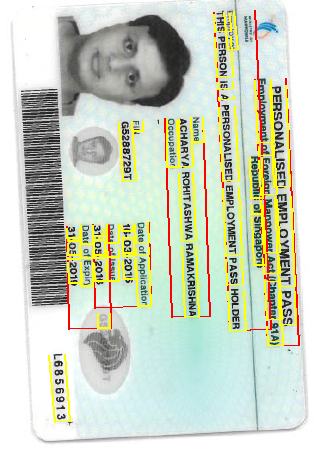

In [0]:
render_doc_text('ml-poc-213704-vcm/EP.png', 0)

In [0]:
async_detect_document('gs://ml-poc-213704-vcm/AliceTan.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
UOB CREDIT CARDS AND UOB CASHPLUS APPLICATION FORM
.
.
:.
:.::...
United Overseas Bank Limited Tel: 1800 222 2121 Fax: 6787 1531
SUPPLEMENTARY CARD APPLICATION (Al fields are mandatory)
Nationality
Country of Residence
Country you he currently residing in or intend to rende In, for more
than I yeur le Singapore)
ID/Passport issuing country:
2 EASY WAYS TO APPLY FAX: 6787 1531 or Mail it back to us
Yes, I would like to have my new card(s) couriered to my mailing address at a nominal fee of S$10.
Please complete all fields and attach the required documents. Applications with incomplete information or supporting
documents will result in delay in processing,
Existing UOB Principal Cardmembers only need to complete Section 1 and 7 and sign under Section 1, For your convenience,
no income documents will be required. If you have had a change of employment, please also complete Section 8 and attach
yo

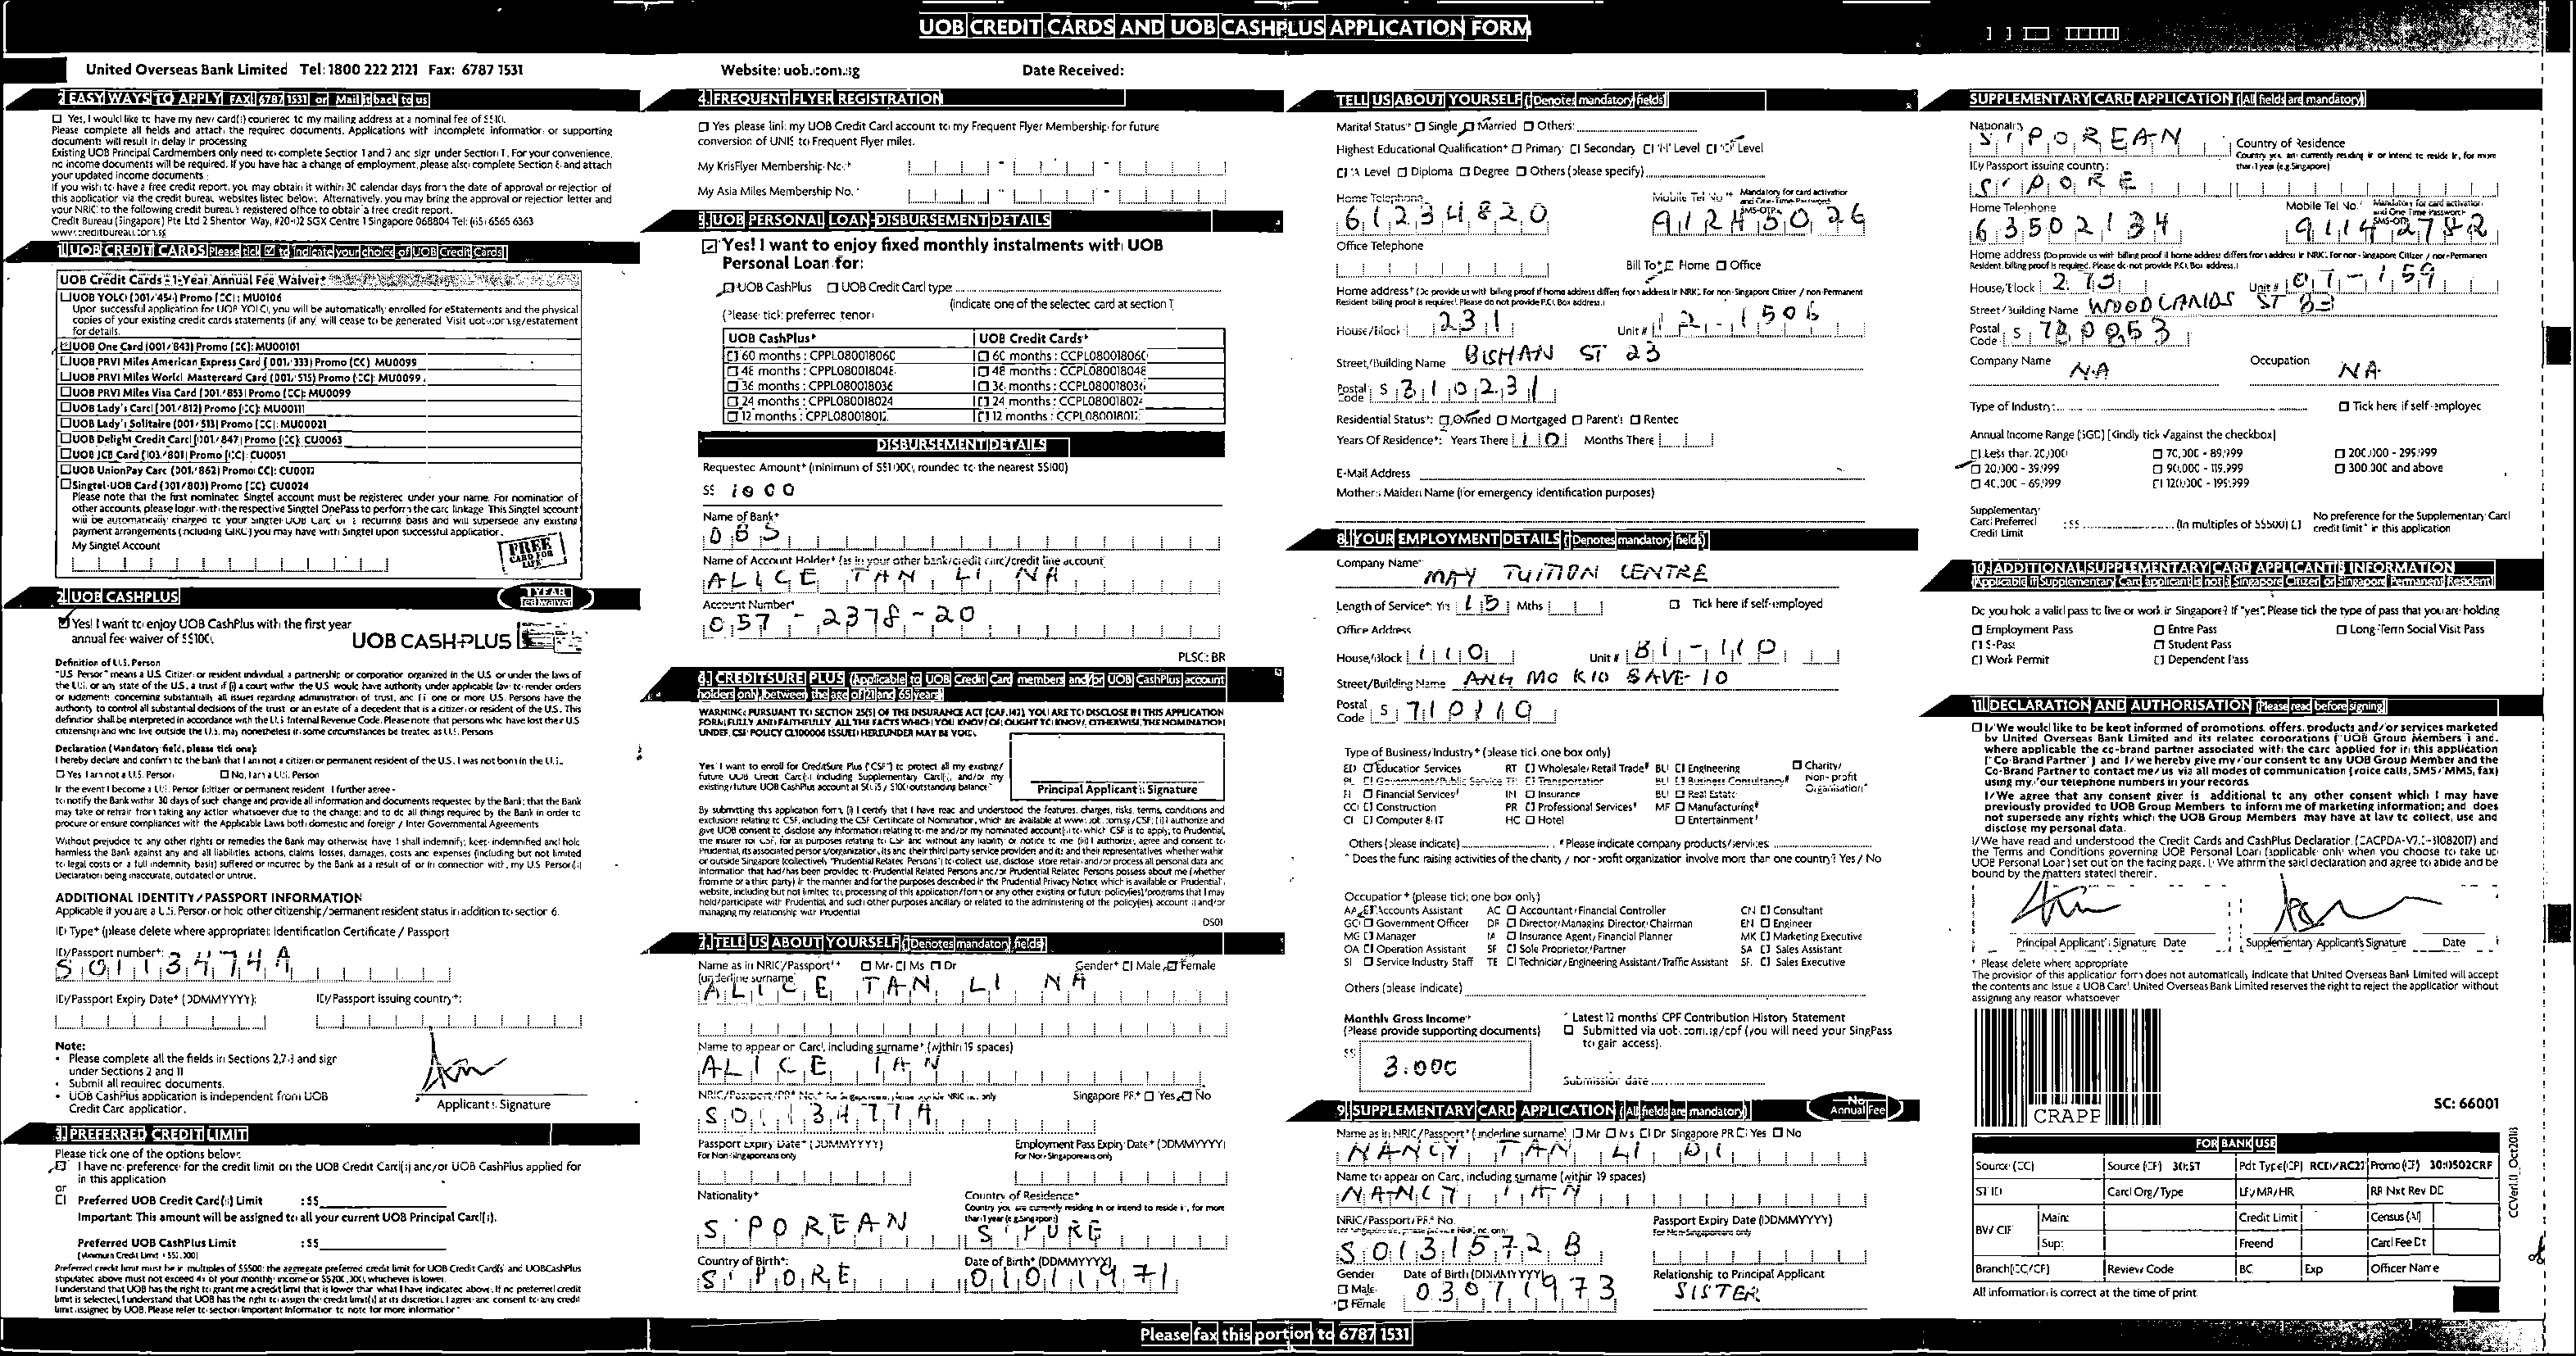

In [0]:
render_doc_text('ml-poc-213704-vcm/AliceTan.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
UOB CREDIT CARDS AND UOB CASHPLUS APPLICATION FORM
United Overseas Bank Limited Tel: 1800 222 2121 Fax: 6787 1531
*
*
-"-
-"--
-
--
SUPPLEMENTARY CARD APPLICATION (A fields are mandātory)
Nationality
Country of Residence
Country you are currently residing In or Intend to reside in for more
ID/Passport issuing country:
then l year leu. Singapore)
UUUUUUUUUUUUUUUUUUUU
Home Telephone
Mobile Tel No Mandatory for card activation
and One-Time Password
SMS-OTP
LILUUUUU
Home address (Do provide us with billing proof if home actress differs from address in NRIC For non-Singapore Citizen / non Permanent
Resident, billing proof is secured. Please do not provide PO Box address)
Unit # LLLLLLLL
Street/Building Name
Code" SUUULUU
Company Name
Occupation
-
--
PALLAAHUL
House/Block UUUU
2 EASY WAYS TO APPLY FAX: 6787 1531 or Mail it back to us'
Yes, I would like to have my new card(s) couriered to my mailing 

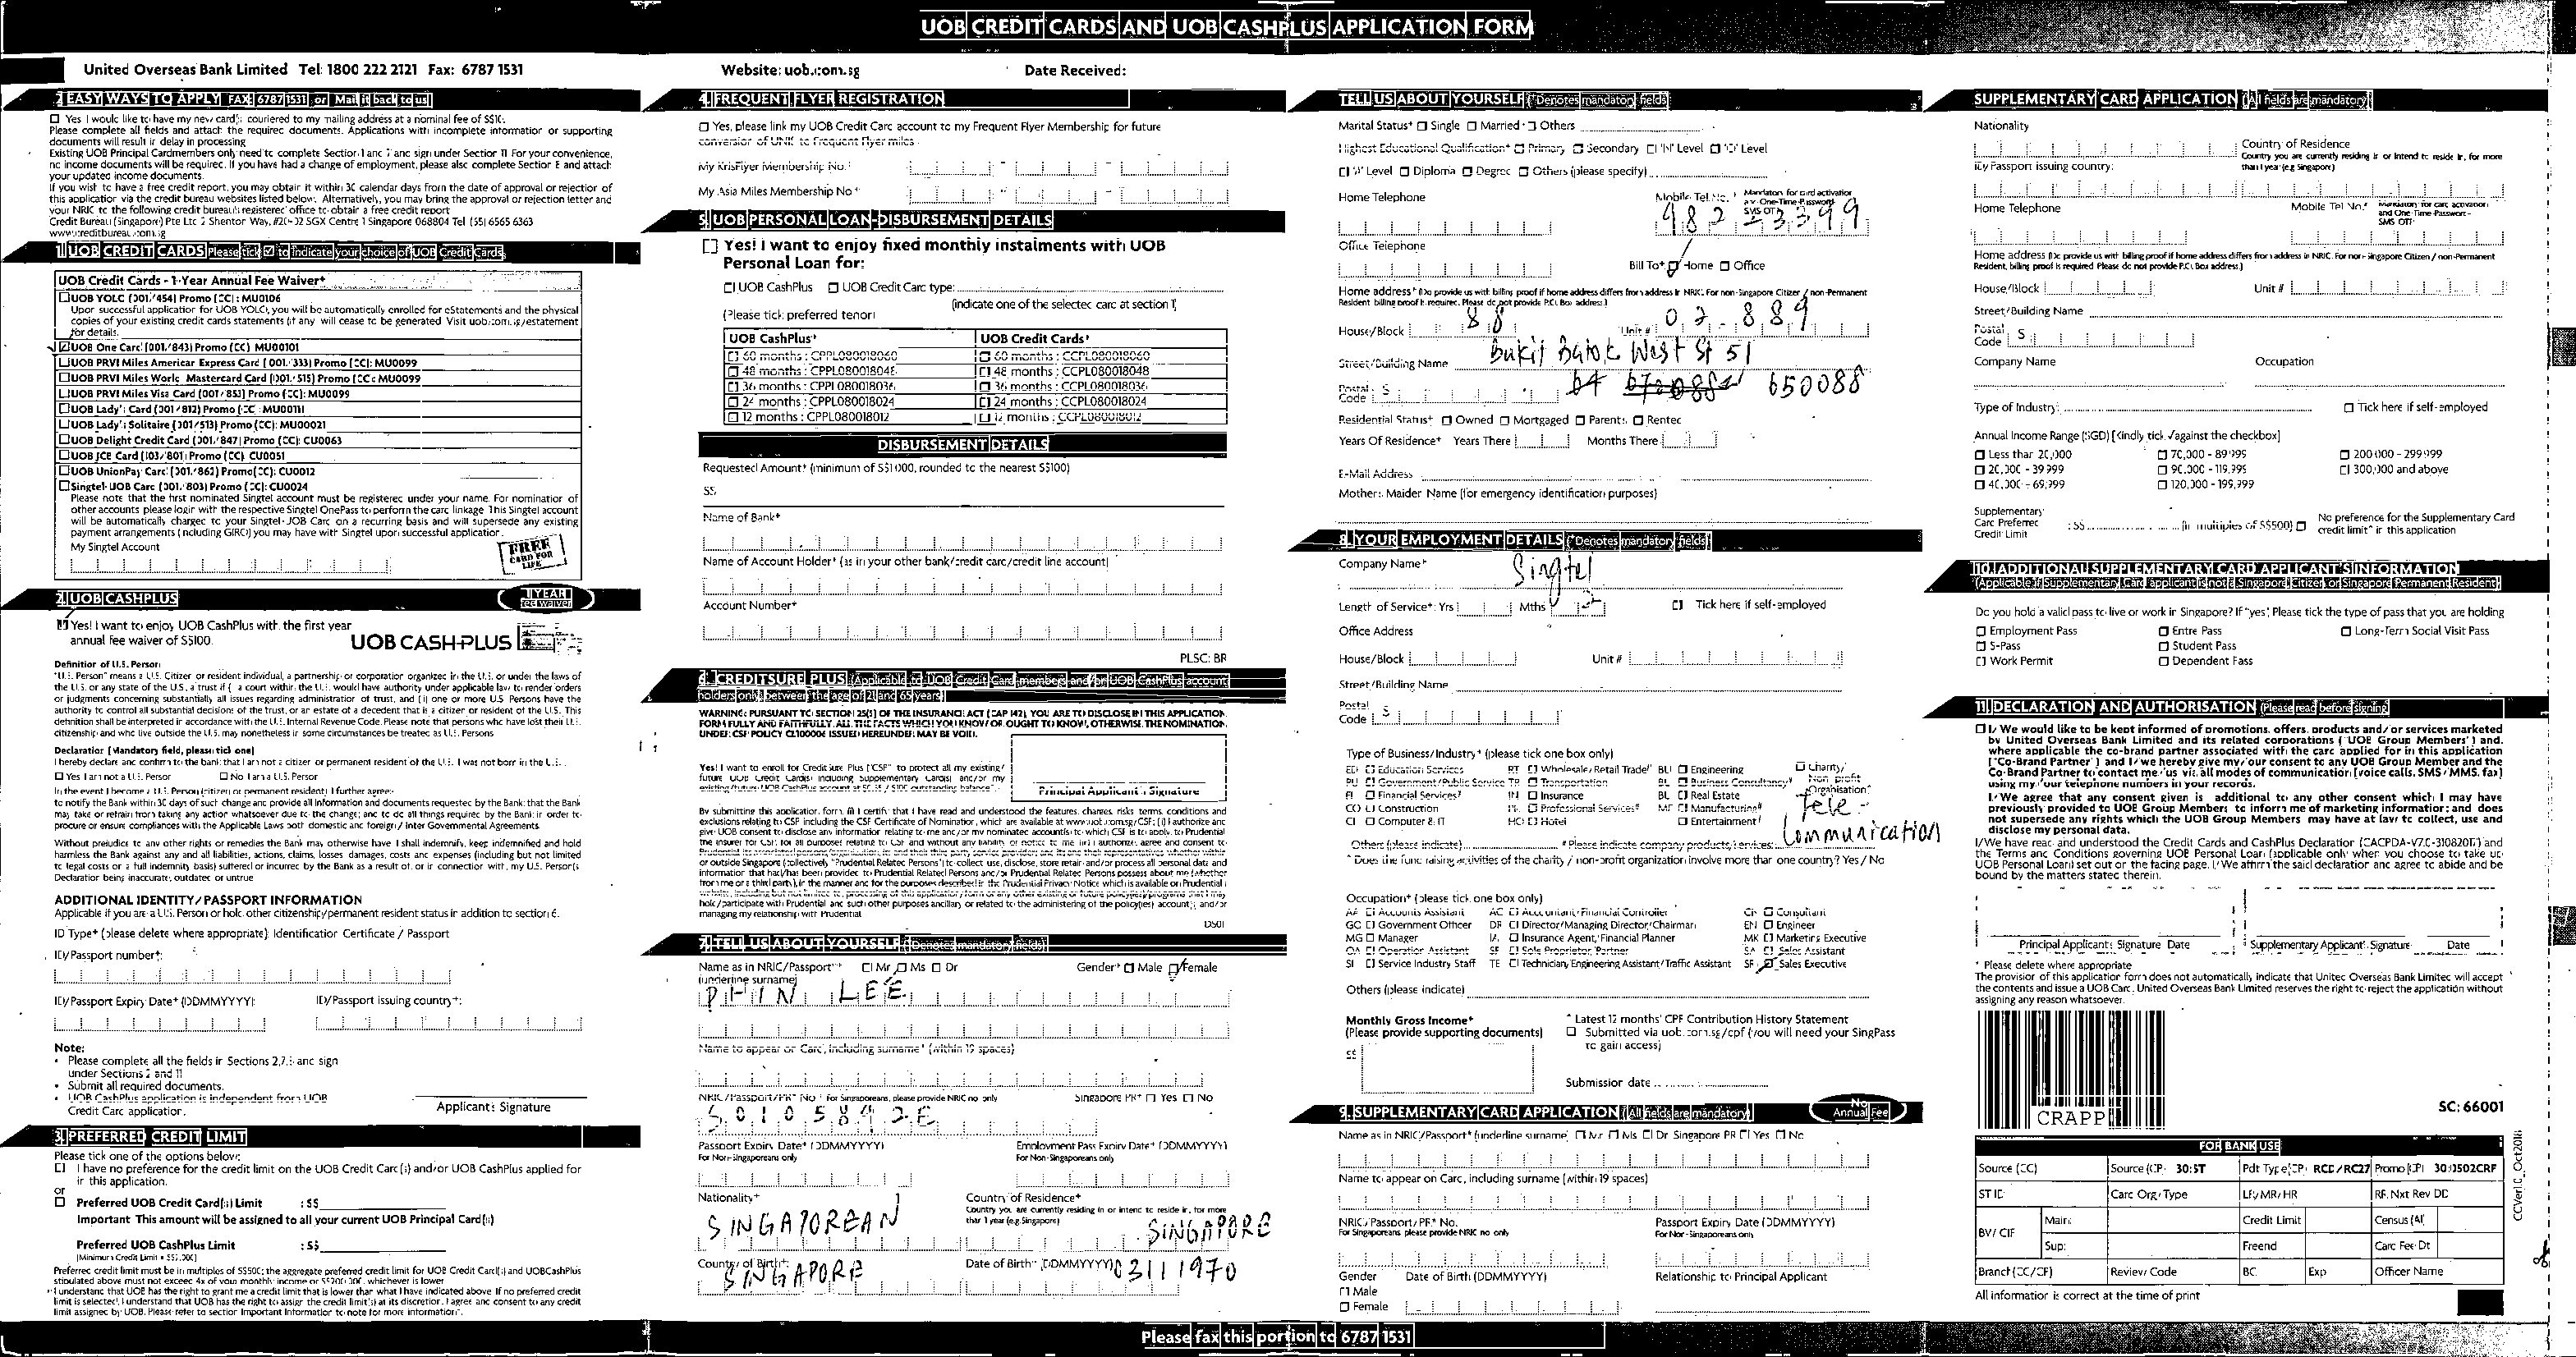

In [0]:
render_doc_text('ml-poc-213704-vcm/PhinLee.tif', 'gs://ml-poc-213704-vcm/upoad/output/')

Waiting for the operation to finish.
Output files:
upoad/output/output-1-to-1.json
Full text:
UOB CREDIT CARDS AND UOB CASHPLUS APPLICATION FORM
-
United Overseas Bank Limited Tel: 1800 222 2121 Fax: 6787 1531
-
-
TELL US ABOUT YOURSELF (Denotes mandatory fiela
Marital Statust a single a Married Others..........
Highest Educational Qualification Primary Secondary O'N' Level O 'O'Level
D'A' level Diploma Degree Others (please specify)..
Home Telephone
Mobile Tel. No *+ Mandatory for card activation
and One-Time-Password
MY I LLUI.
- -
SUPPLEMENTARY CARD APPLICATION (Allfields åre mandatory)
Nationality
UMMYLI UI . 1 Country of Residence
Country you are currently reshing in or intend to reside in for more
ID/Passport issuing country:
than lytur leg Singapore)
LLLLLLLLLLLLUMINIO
Home Telephone
Mobile Tel. No.' Mandatory for card activation
and One Time sex
- -
"
.
........
.
- - -
173,44,49.520
LINDONESIA
678.9.14.5.4 677198841
..0,6 0,3
- -,-
Website: uob.com.sg
Date Received:
4. FREQUEN

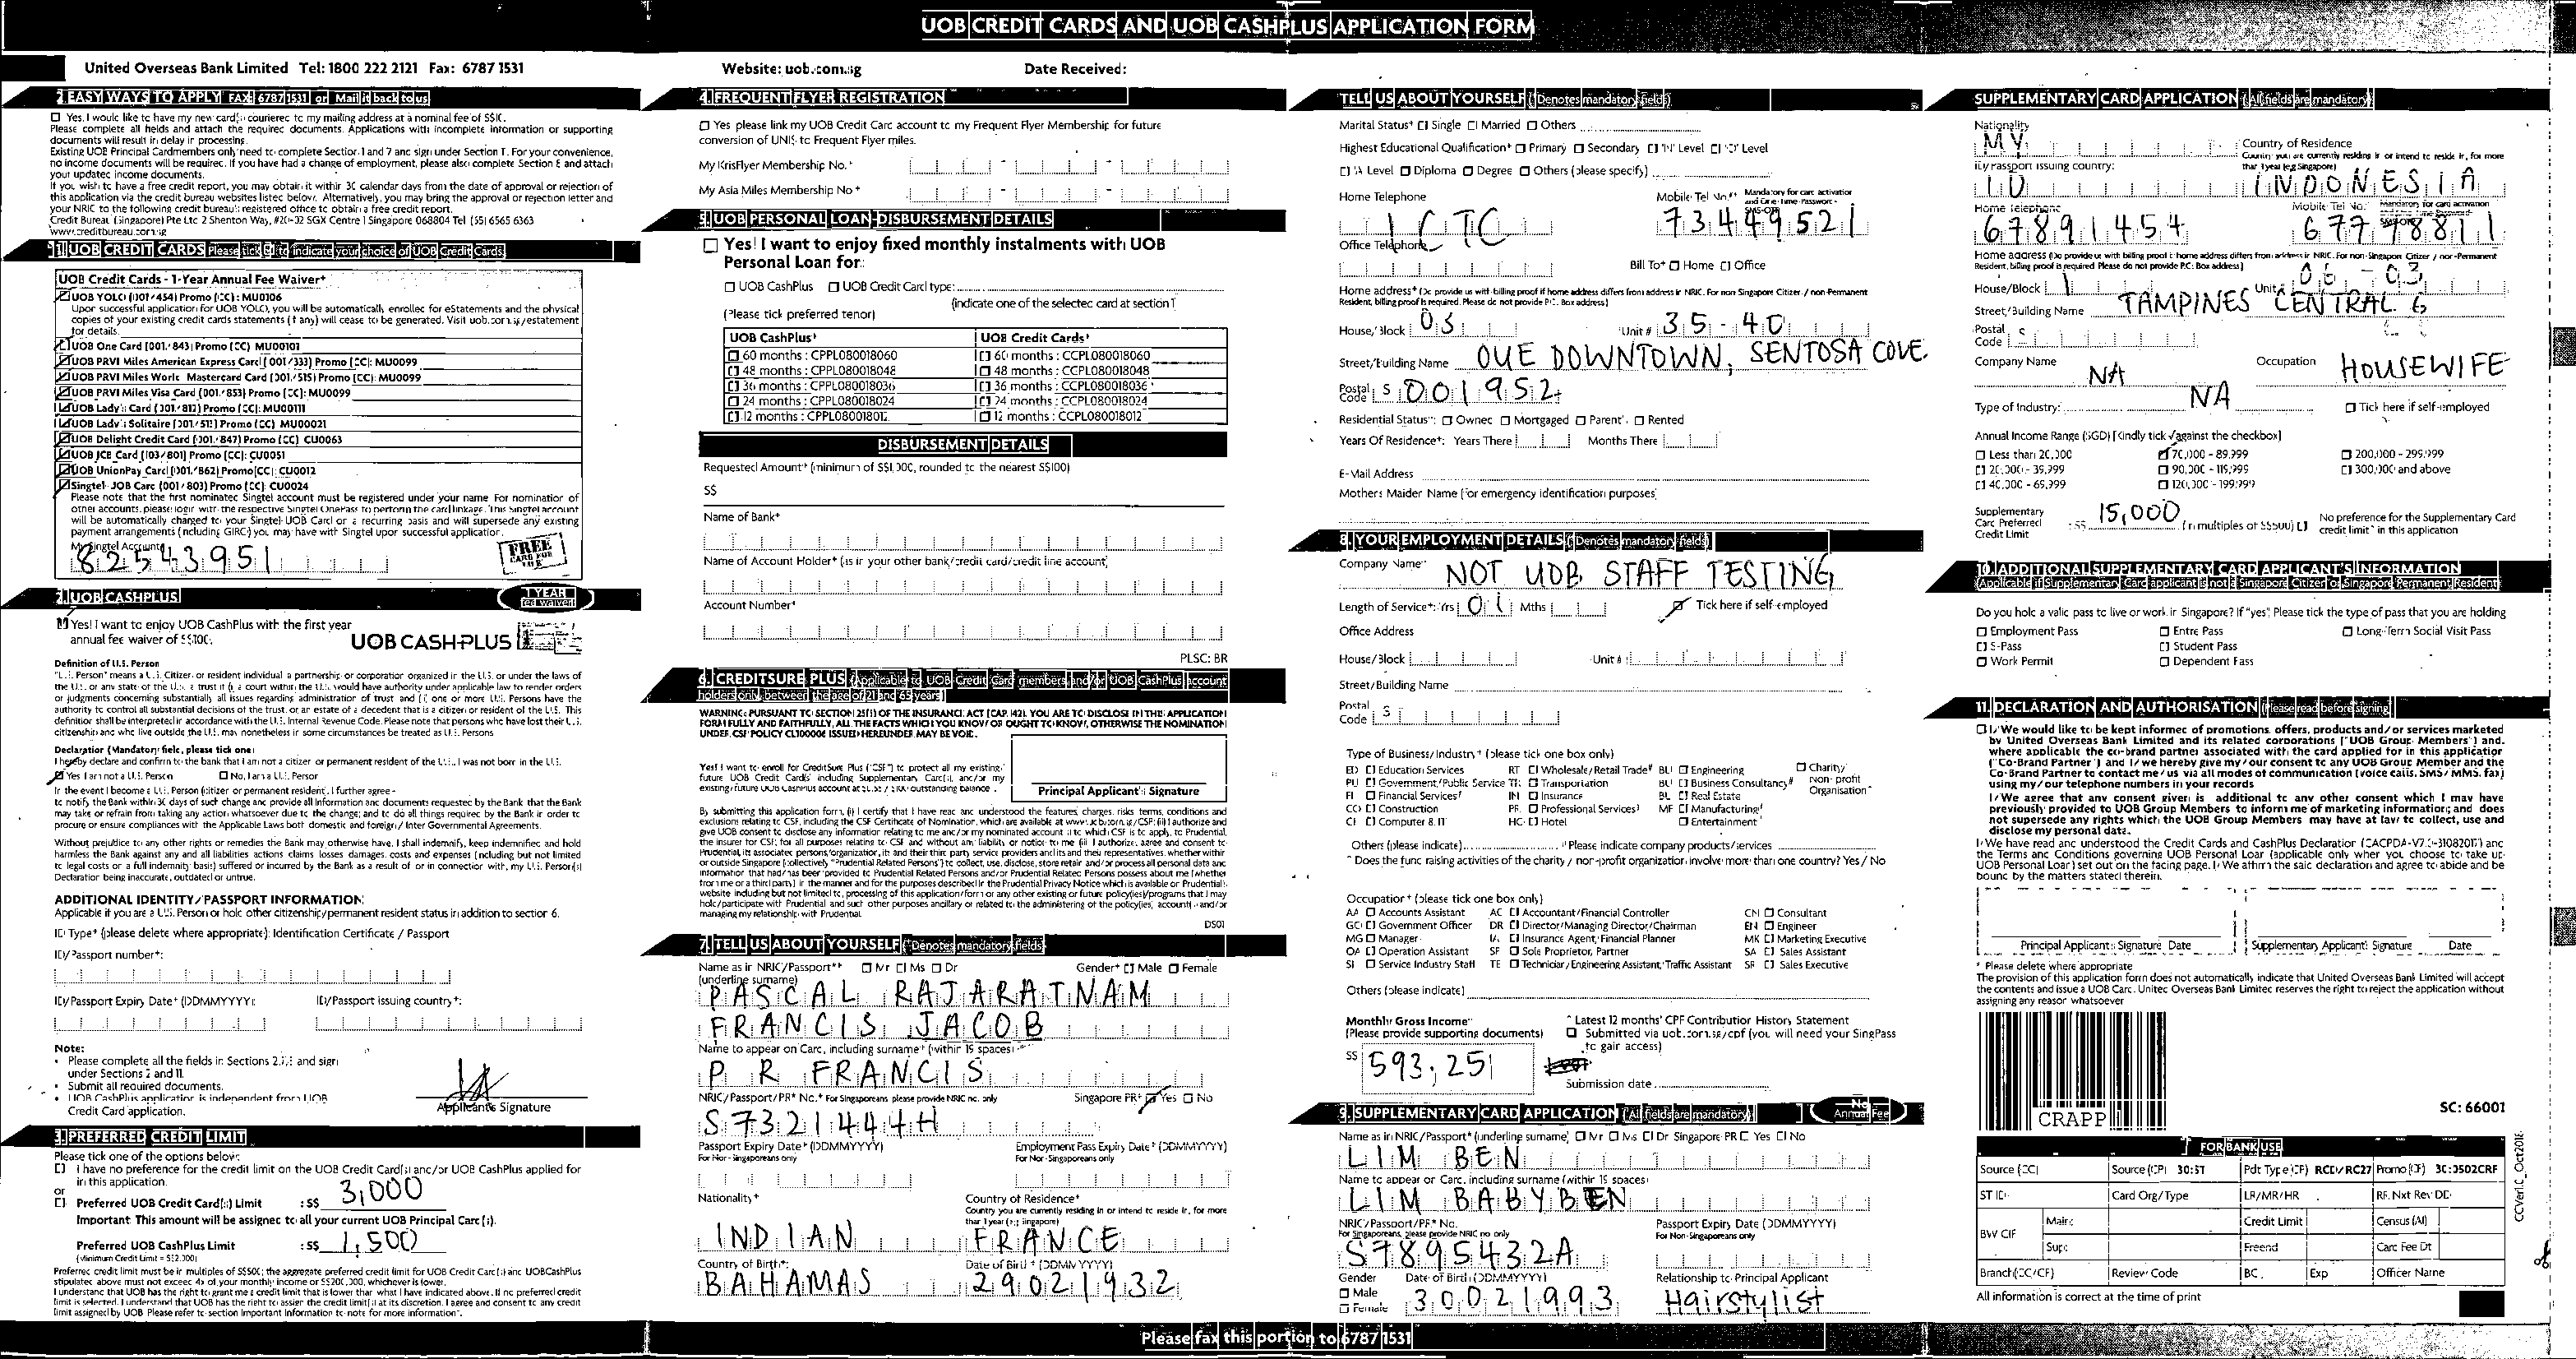

In [0]:
render_doc_text('ml-poc-213704-vcm/PascalRajaratnam.tif', 'gs://ml-poc-213704-vcm/upoad/output/')